# DAY 1: Dynamic Programming, Monte Carlo Methods 

Plan:
- OpenAi Gym for Reinforcement Learning
- MDPs (deterministic and stochastic) and how to solve them (Frozen Lake)
- Monte Carlo Methods (BlackJack)

In [ ]:
!pip install -q --upgrade git+https://github.com/mlss-skoltech/tutorials_week2.git#subdirectory=reinforcement_learning

In [ ]:
from rlutils import plot_values, plot_blackjack_values, plot_policy, show_video, wrap_env

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from IPython.display import display, clear_output
import copy

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [4]:
#from pyvirtualdisplay import Display
#display = Display(visible=0, size=(1400, 900))
#display.start()

# Open AI Gym

<b>What is Open AI Gym?</b>

Open AI Gym is a is a toolkit for developing and comparing reinforcement learning algorithms. This is the gym open-source library, which gives you access to a standardized set of environments that expose a common interface and are versioned to allow for comparisons. 

The Documentation can be found here: http://gym.openai.com/docs/

<br>

Let us have a look at the simple example of using gym environment.

In [7]:
env = gym.make('CartPole-v0')
#env = wrap_env(gym.make('CartPole-v0'))

This is our environment object, with which we can define not only the type of "game" we would like our agent to play 
but also some other settings, like stochasticity, size etc

In [8]:
init_state = env.reset()

Resets the state of the environment and returns an initial state (or observation).

In [9]:
for t in range(100):
    #displays the game in a seperate window
    env.render() 

    #takes a random action
    observation, reward, done, info = env.step(env.action_space.sample())

    #if the agent finishes (dies or reaches the goal) in less then 100 timesteps
    
    """
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
    """

Don't forget to close the environment

In [10]:
env.close() 
#show_video()

## env.step()

is a very important function for us as it allows to pass some actions to the agent. All actions sampled from the policies that we will derive further in this tutoprial should be passed through this function!

The output of env.step() is the following:

- <b>observation</b> (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
- <b>reward</b> (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- <b>done</b> (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- <b>info</b> (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

Gym allows to experiment with many more [environments](https://gym.openai.com/envs/). Some of them are:
- A lot of all ATARI games (Space Invaders, Breakout, Enduro etc)
- Walking robot simulation
- Robotic arm 
- Toy problems 
etc.

To see them all uncomment and run the following cell:

In [11]:
#from gym import envs
#print(envs.registry.all())

# Markov Decision Process

Intuitively, MDP is a way to frame RL tasks such that we can solve them in a "principled" manner. We will go into the specifics throughout this tutorial.

The key in MDPs is the Markov Property - <i>the future depends on the present and not the past</i>.
There's an assumption the present state encapsulates past information. 
Putting into the context of what we have covered so far: our agent can (1) control its action based on its current (2) completely known state


Two main characteristics for MDPs:
- Control over state transitions
- States completely observable

MDP tries to capture the enironment in the following way :

- $S$: set of states
- $A$: set of actions
- $R$: reward function (can be $R(s), R(s,a), R(s,a,s')$)
- $T(s, a , s') \sim Pr(s' | s,a)$: transition-probability function (a.k.a rules of the game, physics of the world etc)
- $\gamma$: discount for future rewards

In a nutshell MDP sets some kind of problem to us, concretely, how the agent should behave (what action should he take in the given state) so that the long term expected reward will be maximized. The solution to this problem is incapsulated in a policy function $\pi(s) \rightarrow a$ (actually, the solution will be something we call an optimal policy: $\pi^*(s)$)

We have an agent acting in an environment. The way the environment reacts to the agent's actions $a$ is dictated by a model. The agent can take actions $a$ to move from one state $s$ to another new state $s$.
When the agent has transitioned to a new state $s$, there will a reward $r$.

We may or may not know our model:
- Model-based RL: this is where we can clearly define our (1) transition probabilities and/or (2) reward function.
The optimal policy can be obtained via Dynamic Programming (DP)
- Model-free RL: this is where we cannot clearly define our (1) transition probabilities and/or (2) reward function. Most real-world problems are under this category.

# FrozenLake enivonement

Let's have a look at one example of an MDP - the environement called Frozen Lake. 
![title](img/frozenlakepic.png)

On each grid, there are 4 possibilities
- **S**: starting point, safe (code = 'SFFF')
- **F**: frozen surface, safe (code = 'FHFH')
- **H**: hole, fall to your doom (code = 'FFFH')
- **G**: goal, where the frisbee is located ('HFFG')

### What is a [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/)? 

Simply put, it is a grid world. However, OpenAi documentation gives us a much more poetic explanation:

<i>Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend.</i>

The surface is described using a grid like the following:

In [12]:
env = gym.make( 'FrozenLake-v0', is_slippery = False) 
env.reset()
env.render()



SFFF
FHFH
FFFH
HFFG


The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:,
```
[[ 0  1  2  3],
 [ 4  5  6  7],
 [ 8  9 10 11],
 [12 13 14 15]],
```

and the agent has 4 potential actions:

In [13]:
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [14]:
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


In this game, we know our transition probability function and reward function, essentially the whole environment, allowing us to turn this game into a simple planning problem via dynamic programming through 4 simple functions:
* (1) policy evaluation
* (2) policy improvement
* (3) policy iteration
* (4) value iteration


## Policy Evaluation

## Deterministic Frozen Lake

MDPs can be divided into two types depending on how the agent acts $a$ in its current state $s$ specified by its policy $\pi(s)$.

It can either be deterministic or stochastic
- Deterministic policy: $a = \pi(s)$
- Stochastic policy: $P_{\pi}[A=a|S=s] = \pi(a|s)$ - the proability of taking an action given the current state under the policy

In [15]:
#the probability of taking an action 0 (LEFT) in a state 1.
env.P[0][LEFT]

[(1.0, 0, 0.0, False)]

### Random policy:

In [16]:
def policy_simulation(env, policy, fps=3):
    state = env.reset()
    rewards, actions = [], []
    while True:
        env.render()
        clear_output(wait=True)

        action = policy(env, state)
        state, reward, done, info = env.step(action)

        rewards.append(reward)
        actions.append(action)

        time.sleep(1./fps)
        if done: 
            if state == 15:
                print('I got the Freezbe!')
            else:
                print('I fell into the hole! Hope I don\'t freeze to death!' ) 

            break;

    env.close()
    
    return actions, rewards

<br>

In [17]:
def random_policy(env, state):
    return env.action_space.sample()#task

In [18]:
actions, rewards = policy_simulation(env, random_policy)

I fell into the hole! Hope I don't freeze to death!


<br>

### Policy evaluation

Rather than estimating value of each state independently, let's use Bellman equation to exploit the relationship between states.

Policy evaluation update rule:
$$
    V_{k+1}(s)
    \leftarrow \sum_{a}\pi(s,a) \sum_{s'} P^a(s \to s') [R_{ss'}^a + \gamma V_k(s′)]
%         \leftarrow \sum_{a} \pi(s,a) \, \mathbb{E}_{s'} R_{s s'}^a + \gamma V_k(s′)
    \,, $$
where $s' \sim P(s' \mid s, a)$.

Apply to every state in each sweep of the state space and repeat over many sweeps
Converges to the fixed point $V_k = V^{\pi}$

<img src="img/policy_eval.png" width="500" height="473" title="Policy evaluation" alt="Policy evaluation">

> [Shimon Whiteson lecture 1 p. 38](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture1_tabular_methods.pdf)


Let us define the policy evaluation function:

<b>input</b>
- ```env```: is an instance of an OpenAI Gym environment, where ```env.P``` returns the one-step dynamics.
- ```policy```: is a 2D numpy array with policy.shape[0] equal to the number of states ```env.nS```, and ```policy.shape[1]``` equal to the number of actions ```env.nA```.  ```policy[s][a]``` returns the probability that the agent takes action a while in state s under the policy.
- ```gamma```: is the discount rate. It must be a value between 0 and 1, inclusive (default value: 1).
- ```theta```: a very small positive number that is used to decide if the estimate has sufficiently converged to the true value function (default value: ```1e-8```).
    
<b>output</b>:
- ```V```: a 1D numpy array with ```V.shape[0]``` equal to the number of states ```env.nS.V[s]``` contains the estimated value of state s under the input policy.
    

In [19]:
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    ### THIS IS THE SOLUTION TO THE TASK###
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            Vs = 0
            # task
            # task
            # task

            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs

        if delta < theta:
            break

    return V

Let's define an initial policy (each action is equiprobable)

In [20]:
init_policy = np.ones([env.nS, env.nA]) / env.nA

And use our ```policy_evalutaion``` function to calculate the state-value function V:

In [21]:
V = policy_evaluation(env, init_policy)

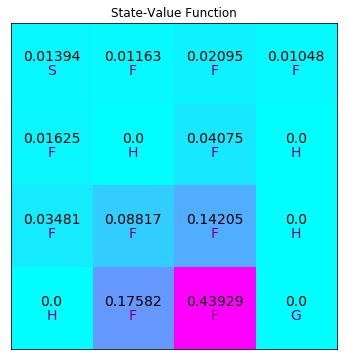

In [22]:
plot_values(V)

So what does $V$ repesent? Basically, each value demonstrates how promising in terms of expected long term rewards is each of the corresponding states.

> If we compare these values to the original Frozen Lake layout, it is clear that the Holes (H) correctly ended up with the corresponding values equal to $0$, and as states come closer to the Freezbe location(G) their values are increasing.

Now how can we translate these values to some actions for our agent? 

$$Q_{\pi}(s,a) = \sum_{s'\in S}P_{ss′}^a[R_{s}^a + \gamma V_k(s′)]$$

Let us define the ```q_from_v``` function:

<b>input</b>
- ```env```: is an instance of an OpenAI Gym environment, where ```env.P``` returns the one-step dynamics.
- ```V```: a 1D numpy array with ```V.shape[0]``` equal to the number of states ```env.nS```. ```V[s]``` contains the estimated value of state s under the input policy.
- ```s```: the current state of the agent

<b>output</b>:
- ```Q```: a 2D numpy array with ```Q.shape[0]``` equal to the number of states ```env.nS``` and ```Q.shape[1]``` equal to the number of actions ```env.nA```. ```Q[s,a]``` contains the calculated values of the action-value function under the input value function.

In [23]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            #task

    return q

In [24]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)

print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.01393977 0.01624865 0.01163091 0.01393977]
 [0.01393977 0.         0.02095297 0.01163091]
 [0.01163091 0.04075153 0.01047648 0.02095297]
 [0.02095297 0.         0.01047648 0.01047648]
 [0.01624865 0.03480619 0.         0.01393977]
 [0.         0.         0.         0.        ]
 [0.         0.14205316 0.         0.02095297]
 [0.         0.         0.         0.        ]
 [0.03480619 0.         0.08816993 0.01624865]
 [0.03480619 0.17582037 0.14205316 0.        ]
 [0.08816993 0.43929118 0.         0.04075153]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.17582037 0.43929118 0.08816993]
 [0.17582037 0.43929118 1.         0.14205316]
 [0.         0.         0.         0.        ]]


In [25]:
# plot_values(Q[:, DOWN])

Notice how those value in the last row are large?


In [26]:
def get_greedy_policy(Q):
    # define a policy `closure`
    def greedy_policy(env, state):
        
        return #task
    
    return greedy_policy


greedy_Q = get_greedy_policy(Q)

actions, rewards = policy_simulation(env, greedy_Q)

I got the Freezbe!


Simple policy evaluation easily solved the deterministic MDP!

But what about non-deterministic environment?

## Non-deterministic Frozen Lake

In [27]:
env = gym.make('FrozenLake-v0', is_slippery = True) #slippery is a factor 
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [28]:
env.P[0][LEFT]

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

In [29]:
V = policy_evaluation(env, init_policy)

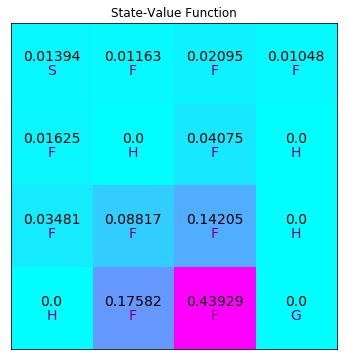

In [30]:
plot_values(V)

In [31]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [32]:
greedy_Q = get_greedy_policy(Q)

actions, rewards = policy_simulation(env, greedy_Q, fps=2)

I fell into the hole! Hope I don't freeze to death!


As we can see from our experiment above the action-value function, which we derived using policy evaluation algorithm for non-deterministic environement is more challenging!

# Policy Improvement and Policy Iteration

Let's maximize q-values per state by choosing actions with highest q-values to get improved policy

In [33]:
#given the value function find the policy
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        
        # OPTION 1: construct a deterministic policy 
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        #Find best action based on max q-value
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy

In [34]:
new_policy = policy_improvement(env, V)

In [35]:
print("Policy Function:")
new_policy

Policy Function:


array([[1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.5 , 0.  , 0.5 , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.25, 0.25, 0.25, 0.25]])

According to the Policy Iteration algorithm loop through policy evaluation (get state-values) and policy improvement functions (use state-values to calculate q-values to improve policy) until optimal policy obtained.

***Aim***: improve policy until convergence (difference of state values between old and new policies is very small (less than theta, a very small positive number))

<img src="img/policy_iter.png" width="500" height="473">

> [Shimon Whiteson lecture 1 p. 42](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture1_tabular_methods.pdf)

In [36]:
def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        ###THIS IS THE SOLUTION###
        #task
        #task
        
        # OPTION 1: stop if the policy is unchanged after an improvement step
        #if (new_policy == policy).all():
        #    break;
        
        # OPTION 2: stop if the value function estimates for successive policies has converged
        if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2: 
            break;
        
        policy = copy.copy(new_policy)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



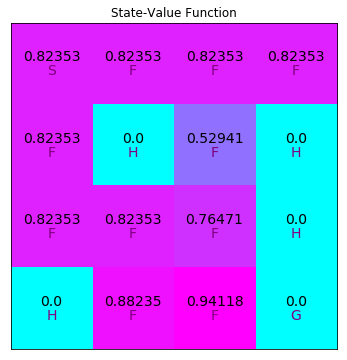

In [37]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

In [38]:
actions, rewards = policy_simulation(env, get_greedy_policy(policy_pi))

I got the Freezbe!


### Value Iteration

An alternative to policy iteration - loop through to find optimal value function then get one-off policy.

Aim: improve value function until convergence (until difference in new and old state values are small (smaller than theta, small positive number)).

<img src="img/value_iter.png" width="500" height="473">

> [Shimon Whiteson lecture 1 p. 44](https://github.com/mlss-skoltech/lectures/blob/master/reinforcement_learning/lecture1_tabular_methods.pdf)

In [39]:
def value_iteration(env, gamma=1, theta=1e-8):
    ###THIS IS THE SOLUTION###
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            #task
            #task
            #task
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]] 



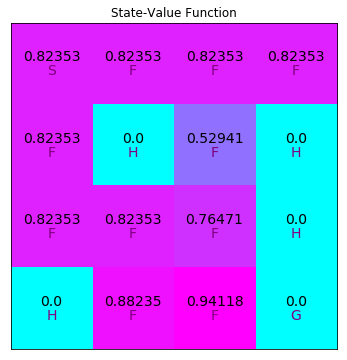

In [40]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

In [41]:
actions, rewards = policy_simulation(env, get_greedy_policy(policy_vi))

I got the Freezbe!


# Monte Carlo methods for Blackjack

MC methods are used on episodic tasks where the model is not known (model-free). The algorithm learns the perfect policy from experience by averaging the sample returns at the end of each episode. 

The FrozenLake environment is a “Perfect Model” where all the transition probabilities between states are defined. Alternatively, MC methods learn probability distributions by generating sample transitions over many episodes. A common toy game to test out MC methods is Blackjack.

In [42]:
import sys
import gym
import numpy as np
from collections import defaultdict


### Blackjack rules (according to openai)

<i>Blackjack is a card game where the goal is to obtain cards that sum to as
 near as possible to 21 without going over.  They're playing against a fixed dealer.
    
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.

The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).

This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto.</i>
http://incompleteideas.net/book/the-book-2nd.html

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).


The agent has two potential actions:
```
    STICK = 0,        
    HIT = 1,
```
Verify this by running the code cell below

In [43]:
env = gym.make('Blackjack-v0')
env.reset()

(9, 4, False)

In [44]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [45]:
def policy_simulation_mc(env, policy, num_episodes=1, silent=True):
    episodes = []
    for i_episode in range(num_episodes):
        state = env.reset()
        while True:            
            action = policy(env, state)
            if not silent:
                print(state)
                if action == 0:
                    print('STICK')
                else:
                    print('HIT')

            next_state, reward, done, info=env.step(action)
            episodes.append((state, action, reward))
            state = next_state
            if done:
                if not silent:
                    print('End game! Reward: ', reward)
                    if reward > 0:
                        print('You won :) (lucky you)\n')  
                    elif reward ==0:
                        print('A draw! (lucky you)\n')  
                    else:
                        print('You lost :( (gambling is a bad habit anyway)\n')
                break
    return episodes

In [46]:
policy_simulation_mc(env, random_policy, num_episodes = 3, silent = False)

(15, 10, False)
HIT
End game! Reward:  -1
You lost :( (gambling is a bad habit anyway)

(11, 3, False)
HIT
(21, 3, False)
STICK
End game! Reward:  1.0
You won :) (lucky you)

(18, 7, False)
STICK
End game! Reward:  1.0
You won :) (lucky you)



[((15, 10, False), 1, -1),
 ((11, 3, False), 1, 0),
 ((21, 3, False), 0, 1.0),
 ((18, 7, False), 0, 1.0)]

Let us investigate the particular policy that may lead us to victory. What if each time the sum of our cards gets $> 18$, we STICK, and if this sum is $\leq 18$ we hit and ask for more cards?

In [47]:
def limit_stochastic_policy(env, state):
    probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]#task
    return np.random.choice(np.arange(2), p=probs)

In [50]:
policy_simulation_mc(env, limit_stochastic_policy, num_episodes = 1, silent = False)

(20, 3, True)
STICK
End game! Reward:  1.0
You won :) (lucky you)



[((20, 3, True), 0, 1.0)]

In order to construct better policies, we need to first be able to evaluate any policy. If an agent follows a policy for many episodes, using Monte-Carlo Prediction, we can construct the Q-table (i.e. “estimate” the action-value function ) from the results from these episodes.

In order to create a Q-table we’ll need to keep track of reward we got for each state,action pair we visited and also keep a track of how many times we visited the state say an N-table.
Depending on which returns are chosen, we estimate our Q-values.

<img src="img/monte_carlo_every.png" width="500" height="473">

In the pseudocode above calculate Q function instead of V (don't forget that Q takes a ***state-action*** pair as an argument)

In [51]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        #learn the value functions directly from episodes of experience. 
        # generate an episode
        episode = generate_episode(env, limit_stochastic_policy)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])#task
            N[state][actions[i]] += 1.0#task
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]#task
    return Q

In [52]:
# obtain the action-value function
Q = mc_prediction_q(env, 500000, policy_simulation_mc)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

Episode 500000/500000.

In [53]:
policy = dict((k,np.argmax(v)) for k, v in Q.items())

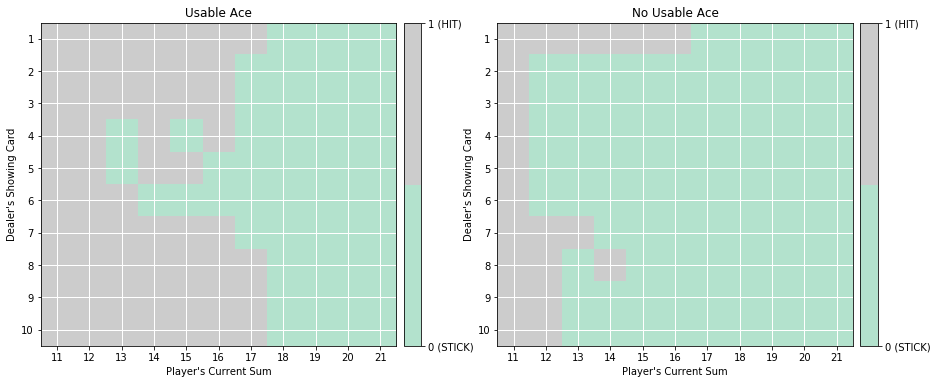

In [54]:
plot_policy(policy)

In [55]:
def get_mc_pred_policy(policy):
    # define a policy `closure`
    def mc_pred_policy(env, state):
        return policy[state]
    return mc_pred_policy

In [56]:
mc_prediction = get_mc_pred_policy(policy)
policy_simulation_mc(env, mc_prediction, num_episodes=3, silent=False)

(12, 8, False)
HIT
(20, 8, False)
STICK
End game! Reward:  1.0
You won :) (lucky you)

(18, 6, True)
STICK
End game! Reward:  1.0
You won :) (lucky you)

(13, 9, False)
STICK
End game! Reward:  -1.0
You lost :( (gambling is a bad habit anyway)



[((12, 8, False), 1, 0),
 ((20, 8, False), 0, 1.0),
 ((18, 6, True), 0, 1.0),
 ((13, 9, False), 0, -1.0)]

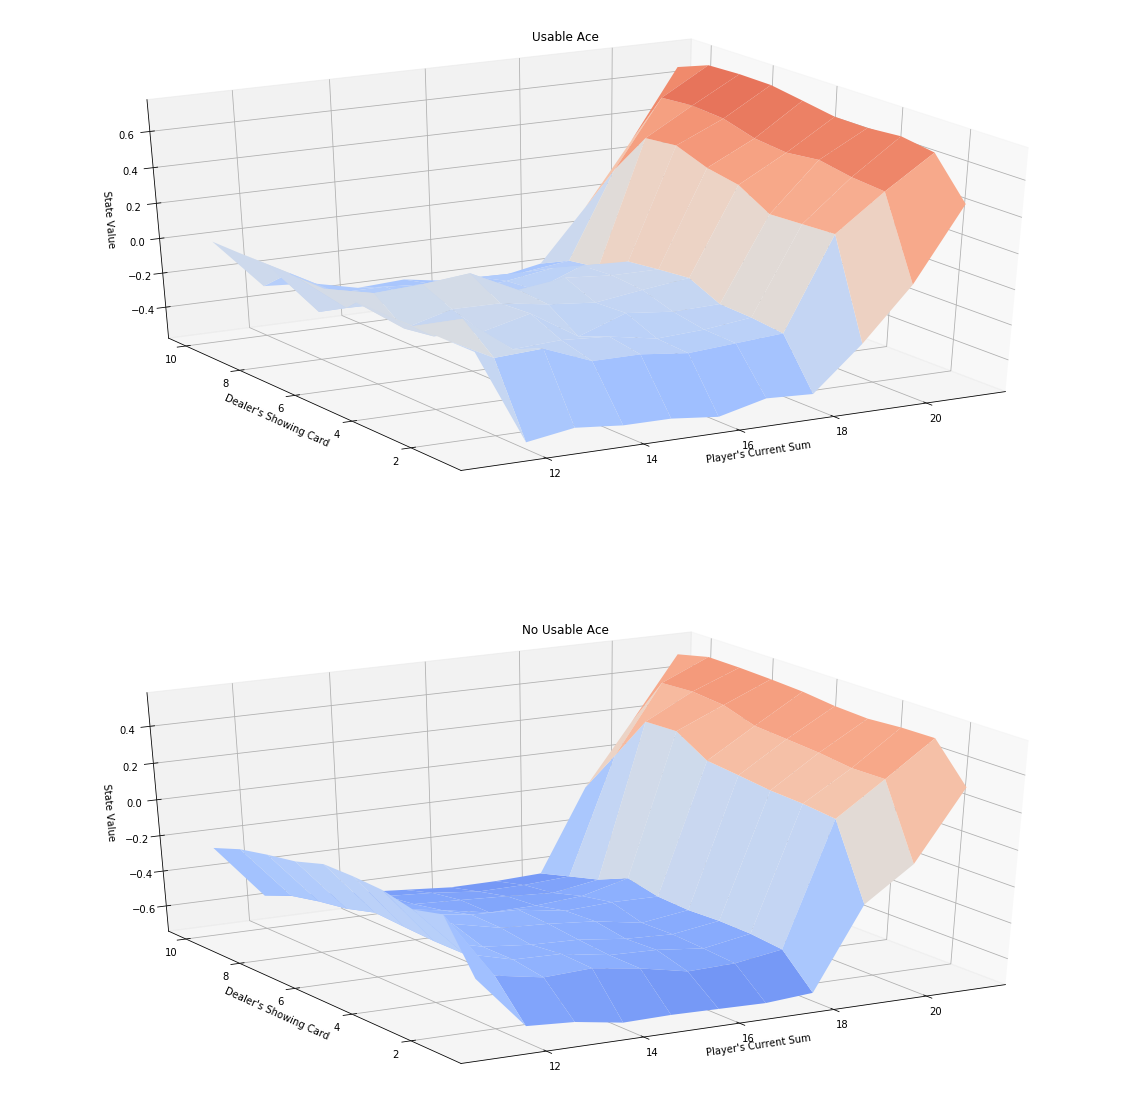

In [57]:
plot_blackjack_values(V_to_plot)

So now we know how to estimate the action-value function for a policy, how do we improve on it? Using the …

## Monte-Carlo Control Algorithm

We start with a stochastic policy and compute the Q-table using MC prediction. So we now have the knowledge of which actions in which states are better than other i.e. they have greater Q-values. We can improve upon our existing policy by just greedily choosing the best action at each state as per our knowledge i.e. Q-table and then recompute the Q-table and chose next policy greedily and so on! 

However, we will now face:
- Exploration-exploitation problem ($\epsilon$-greedy policy)
- Decreasing an incremental change term (use a constant hyperparameter instead) (i.e. change $1/N$ to some $\alpha$)

<img src="img/monte_carlo_off.png" width="500" height="473">

In [58]:
def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA

    # a^* \leftarrwow \arg\max_a Q_s(a)
    best_a = np.argmax(Q_s)

    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [59]:
def policy_from_Q(Q, epsilon):

    def mc_impov(env, state):
        if state not in Q:
            return env.action_space.sample()

        probs = get_probs(Q[state], epsilon, env.action_space.n)
        return np.random.choice(env.action_space.n, p=probs)

    return mc_impov

In [60]:
def get_policy_simulation_mc_c(env, Q, epsilon):
    policy = policy_from_Q(Q, epsilon)

    return policy_simulation_mc(env, policy)

In [61]:
def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    ###THIS IS THE SOLUTION
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] #task
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)#task
    return Q

In [62]:
def mc_control(env, num_episodes, generate_episode, alpha, gamma=1.0, eps_start=1.0, 
               eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode(env, Q, epsilon)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [63]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, get_policy_simulation_mc_c, 0.02)

Episode 500000/500000.

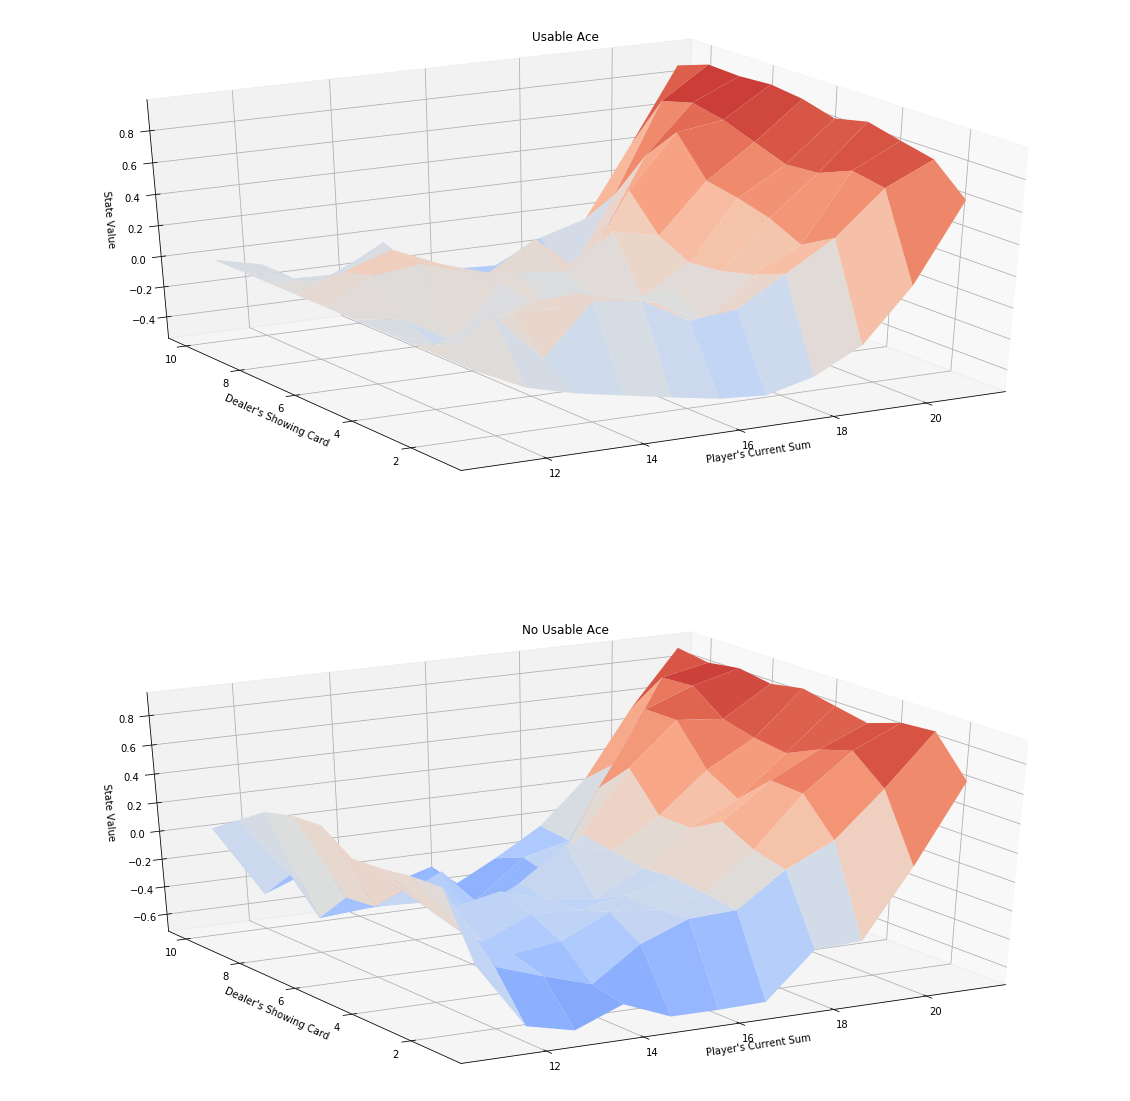

In [64]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

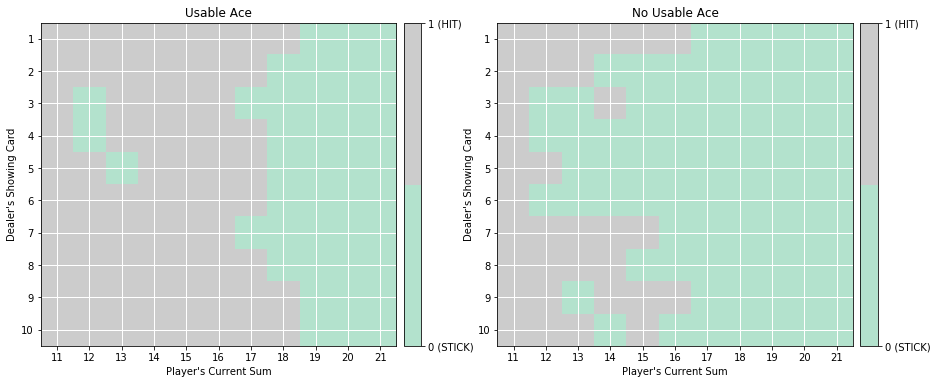

In [65]:

# plot the policy
plot_policy(policy)

In [66]:
rewards = []
for i_episode in range(3):
    state = env.reset()
    while True:
        print(state) 
        action = policy[state]
        if action == 0:
            print('STICK')
        else:
            print('HIT')
        state, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            print('End game! Reward: ', reward)
            print('You won :) (lucky you)\n') if reward > 0 else print('You lost :( (gambling is a bad habit anyway)\n')
            break

(7, 6, False)
HIT
(18, 6, True)
STICK
End game! Reward:  0.0
You lost :( (gambling is a bad habit anyway)

(17, 10, True)
HIT
(17, 10, False)
STICK
End game! Reward:  -1.0
You lost :( (gambling is a bad habit anyway)

(13, 10, False)
HIT
End game! Reward:  -1
You lost :( (gambling is a bad habit anyway)



And here is the true optimal policy $\pi_*$ can be found in Figure 5.2 of the R.Sutton and A. Barto "Reinforcement Learning. An Introduction". Compare your final estimate to the optimal policy - how close are you able to get? If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

<img src="img/right_policy.png" width="700" height="573">